Importing libraries

In [902]:
# importing required libraries 
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

from sklearn.linear_model import LogisticRegression 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score, roc_curve, auc

Loading & reviewing the dataset

In [904]:
# loading the dataset 
diabetes_df = pd.read_csv('Dataset_of_Diabetes.csv')

In [905]:
# checking dat structure
print(diabetes_df.head())

    ID  No_Pation Gender  AGE  Urea  Cr  HbA1c  Chol   TG  HDL  LDL  VLDL  \
0  502      17975      F   50   4.7  46    4.9   4.2  0.9  2.4  1.4   0.5   
1  735      34221      M   26   4.5  62    4.9   3.7  1.4  1.1  2.1   0.6   
2  420      47975      F   50   4.7  46    4.9   4.2  0.9  2.4  1.4   0.5   
3  680      87656      F   50   4.7  46    4.9   4.2  0.9  2.4  1.4   0.5   
4  504      34223      M   33   7.1  46    4.9   4.9  1.0  0.8  2.0   0.4   

    BMI CLASS  
0  24.0     N  
1  23.0     N  
2  24.0     N  
3  24.0     N  
4  21.0     N  


In [906]:
#rechecking summary stats
diabetes_df.describe()

,ID,No_Pation,AGE,Urea,Cr,HbA1c,Chol,TG,HDL,LDL,VLDL,BMI
count,947.000000,9.470000e+02,947.000000,947.000000,947.000000,947.000000,947.000000,947.000000,947.000000,947.000000,947.000000,947.000000
mean,337.390707,2.820946e+05,54.101373,5.159074,69.103485,8.408617,4.878691,2.362101,1.209081,2.616304,1.903485,29.893897
std,238.938561,3.473737e+06,8.499612,2.975024,60.862961,2.544040,1.313356,1.417275,0.672423,1.127316,3.757012,4.869852
min,1.000000,1.230000e+02,20.000000,0.500000,6.000000,0.900000,0.000000,0.300000,0.200000,0.300000,0.100000,19.000000
25%,125.000000,2.406350e+04,51.000000,3.700000,48.000000,6.800000,4.000000,1.500000,0.900000,1.800000,0.700000,27.000000
50%,295.000000,3.439000e+04,55.000000,4.600000,60.000000,8.100000,4.800000,2.000000,1.100000,2.500000,1.000000,30.000000
75%,546.500000,4.536950e+04,59.000000,5.700000,73.000000,10.200000,5.600000,2.900000,1.300000,3.300000,1.500000,33.000000
max,800.000000,7.543566e+07,79.000000,38.900000,800.000000,16.000000,10.300000,13.800000,9.900000,9.900000,35.000000,47.750000


In [907]:
# a summary of dataset, including data types and non-null counts
print(diabetes_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 947 entries, 0 to 946
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   ID         947 non-null    int64  
 1   No_Pation  947 non-null    int64  
 2   Gender     947 non-null    object 
 3   AGE        947 non-null    int64  
 4   Urea       947 non-null    float64
 5   Cr         947 non-null    int64  
 6   HbA1c      947 non-null    float64
 7   Chol       947 non-null    float64
 8   TG         947 non-null    float64
 9   HDL        947 non-null    float64
 10  LDL        947 non-null    float64
 11  VLDL       947 non-null    float64
 12  BMI        947 non-null    float64
 13  CLASS      947 non-null    object 
dtypes: float64(8), int64(4), object(2)
memory usage: 103.7+ KB
None


In [908]:
# checks for missing values
print(diabetes_df.isnull().sum())

ID           0
No_Pation    0
Gender       0
AGE          0
Urea         0
Cr           0
HbA1c        0
Chol         0
TG           0
HDL          0
LDL          0
VLDL         0
BMI          0
CLASS        0
dtype: int64


In [909]:
# checks for any duplicate rows
print(diabetes_df.duplicated().sum())

0


In [910]:
# checking class balance in the dataset
print(diabetes_df['CLASS'].value_counts())

CLASS
Y     840
N     102
Y       4
N       1
Name: count, dtype: int64


In [911]:
# cleaning class labels to remove spaces and make all uppercase
diabetes_df['CLASS'] = diabetes_df['CLASS'].str.strip().str.upper()

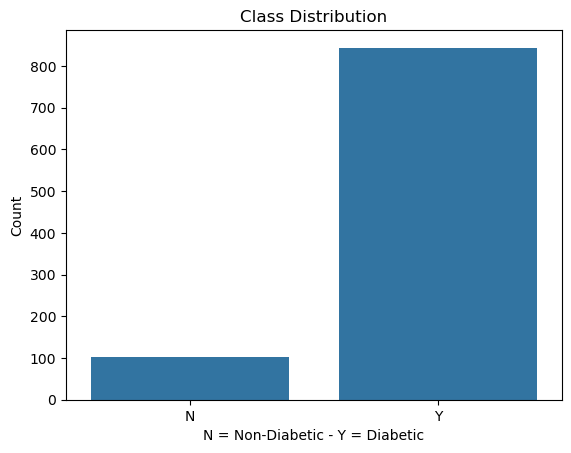

In [912]:
# visualising the cleaned class distribution
sns.countplot(x=diabetes_df['CLASS'])
plt.title('Class Distribution')
plt.xlabel('N = Non-Diabetic - Y = Diabetic')
plt.ylabel('Count')
plt.show()

In [913]:
# dropping irrelevant features that do not contribute to prediction
diabetes_df = diabetes_df.drop(columns = ['Gender','ID', 'No_Pation'])

In [914]:
# checking remaining features after dropping irrelevant columns
print(diabetes_df.columns)

Index(['AGE', 'Urea', 'Cr', 'HbA1c', 'Chol', 'TG', 'HDL', 'LDL', 'VLDL', 'BMI',
       'CLASS'],
      dtype='object')


Preprocessing 1 : outlier handling, filtering, feature capping, encoding and correlation analysis 

IQR Method for outliers

In [917]:
# handling outliers using the IQR method
for col in ['Urea', 'Cr', 'HbA1c', 'Chol', 'TG', 'HDL', 'LDL', 'VLDL', 'BMI']:
    q1 = diabetes_df[col].quantile(0.25)
    q3 = diabetes_df[col].quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr

    #identifying outliers
    outliers = diabetes_df[(diabetes_df[col] < lower) | (diabetes_df[col] > upper)] 

    # printing number of outliers detected for each column
    if not outliers.empty:
       print(f'{col}: {len(outliers)} outliers')
       print('Head:\n', outliers[[col]].sort_values(by=col).head(10))  
       print('Tail:\n', outliers[[col]].sort_values(by=col).tail(10))

Urea: 64 outliers
Head:
      Urea
503   0.5
930   8.8
915   8.8
463   8.9
724   9.0
774   9.0
916   9.0
906   9.1
168   9.1
796   9.2
Tail:
      Urea
793  20.8
220  20.8
230  20.8
95   22.0
480  22.0
536  24.0
537  24.0
539  24.0
839  26.4
831  38.9
Cr: 51 outliers
Head:
       Cr
69     6
353  111
354  111
864  111
549  112
932  113
919  113
906  114
629  120
463  120
Tail:
       Cr
754  327
159  370
155  370
539  401
537  401
536  401
793  800
230  800
220  800
807  800
HbA1c: 6 outliers
Head:
      HbA1c
80     0.9
92     0.9
98     0.9
101    0.9
752   15.9
844   16.0
Tail:
      HbA1c
80     0.9
92     0.9
98     0.9
101    0.9
752   15.9
844   16.0
Chol: 27 outliers
Head:
      Chol
99    0.0
20    0.5
289   0.6
292   0.6
671   1.2
778   8.0
777   8.0
773   8.1
689   8.4
359   8.5
Tail:
      Chol
124   9.5
123   9.5
48    9.5
41    9.5
614   9.7
723   9.7
471   9.8
868   9.8
470   9.9
609  10.3
TG: 53 outliers
Head:
       TG
576  5.1
573  5.1
559  5.1
556  5.1
551  5.1
542  

Filtering rows to remove extreme values

In [919]:
# filtering/removing medically unrealistic values based on researched clinical thresholds
diabetes_df = diabetes_df[
    (diabetes_df['Chol'] > 0) &  
    (diabetes_df['HbA1c'] >= 1) &  
    (diabetes_df['HDL'] >= 0.5)] 

In [920]:
# rechecking summary stats after removing extreme values
print(diabetes_df.describe())

              AGE        Urea          Cr       HbA1c        Chol          TG  \
count  934.000000  934.000000  934.000000  934.000000  934.000000  934.000000   
mean    54.026767    5.093087   68.067452    8.441178    4.897131    2.356649   
std      8.509394    2.794687   58.253620    2.505963    1.302751    1.418181   
min     20.000000    0.500000    6.000000    2.000000    0.500000    0.300000   
25%     51.000000    3.700000   48.000000    6.800000    4.100000    1.500000   
50%     55.000000    4.600000   60.000000    8.200000    4.800000    2.000000   
75%     59.000000    5.700000   73.000000   10.200000    5.600000    2.900000   
max     79.000000   38.900000  800.000000   16.000000   10.300000   13.800000   

              HDL         LDL        VLDL         BMI  
count  934.000000  934.000000  934.000000  934.000000  
mean     1.217559    2.615567    1.915310   29.927794  
std      0.672286    1.131982    3.781567    4.859921  
min      0.500000    0.300000    0.100000   19

Capping the extreme values 

In [922]:
# capping extreme values using medically informed to reduce outlier impact
col_caps = {
    'Urea' : (5,30),
    'Cr' : (45,200), 
    'HbA1c' : (None, 16),
    'Chol' : (None, 9),
    'TG' : (None, 10), 
    'HDL' : (None, 4), 
    'LDL' : (None, 7), 
    'VLDL' : (None, 10), 
    'BMI' : (None, 45)
}

#  # apply clipping to capped values
for col, (lower, upper) in col_caps.items():
    diabetes_df[col] = diabetes_df[col].clip(lower=lower, upper=upper)

In [923]:
# converting class labels from strings to binary integers 0 and 1
diabetes_df['CLASS'] = diabetes_df['CLASS'].replace({'N': 0 , 'Y': 1}).astype(int)

# confirming successful encoding of class
print(diabetes_df['CLASS'].unique()) 

[0 1]


C:\Users\bianc\AppData\Local\Temp\ipykernel_11392\3869728564.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  diabetes_df['CLASS'] = diabetes_df['CLASS'].replace({'N': 0 , 'Y': 1}).astype(int)


Plotting the correlations as a Heatmap 

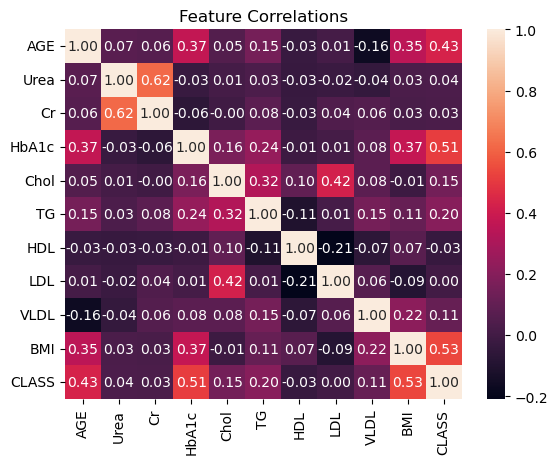

In [925]:
# calculating feature correlations to detect multicollinearity
diabetes_corr = diabetes_df.corr()

# visualising correlation matrix as a heatmap
sns.heatmap(diabetes_corr, annot=True, fmt='.2f')
plt.title('Feature Correlations')
plt.show()

In [926]:
# dropping BMI for multicollinearity
diabetes_df = diabetes_df.drop(columns=['BMI'])

Preprocessing 2: encoding, stratified train-test split, smote and feature scaling

In [928]:
# defining feature variables X and target variable y
X = diabetes_df.drop(columns=['CLASS'])
y = diabetes_df['CLASS']

In [929]:
# splitting data using stratified shuffle split to maintain class balance in train and test sets
strat_split = StratifiedShuffleSplit(n_splits=1, test_size=0.4, random_state=42)

In [930]:
# creating train and test sets using the split indices
for train_index, test_index in strat_split.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

print('Train class distribution:\n', y_train.value_counts())
print('Test class distribution:\n', y_test.value_counts())

Train class distribution:
 CLASS
1    501
0     59
Name: count, dtype: int64
Test class distribution:
 CLASS
1    335
0     39
Name: count, dtype: int64


Applying SMOTE to balance class

In [932]:
# applying smote to balance the class distribution in the training set
smote_sample = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote_sample.fit_resample(X_train, y_train)

# confirming class balance after SMOTE and verifying test set remains unchanged
print('After SMOTE (y_train_bal distribution):\n', y_train_bal.value_counts())
print('Test class distribution:\n', y_test.value_counts())

After SMOTE (y_train_bal distribution):
 CLASS
1    501
0    501
Name: count, dtype: int64
Test class distribution:
 CLASS
1    335
0     39
Name: count, dtype: int64


Scaling the data

In [934]:
# scaling feature values to standardise the data for model training
std_scaler = StandardScaler()
X_train_scaled = std_scaler.fit_transform(X_train_bal)
X_test_scaled = std_scaler.transform(X_test)

Training models - Logistic Regression, KNN, SVC, Naive Bayes & XGBoost

--- Logistic Regression ---

In [937]:
# initialising the logistic regression model and setting regularisation parameter C to 0.01
log_reg = LogisticRegression(class_weight='balanced', C=0.01, random_state=42)

In [938]:
# fitting the logistic reg model to the scaled training data
log_reg.fit(X_train_scaled, y_train_bal)

LogisticRegression(C=0.01, class_weight='balanced', random_state=42)

In [939]:
# predicting using the trained logistic regression model with scaled test data
y_predict = log_reg.predict(X_test_scaled)

In [940]:
# evaluating the logistic regression model performance on the test set
train_acc_log = log_reg.score(X_train_scaled, y_train_bal)
test_acc_log = log_reg.score(X_test_scaled, y_test)

# print accuracies
print(f'Train Accuracy: {train_acc_log:.2f}')
print(f'Test Accuracy: {test_acc_log:.2f}')

# print the classification report for precision, recall, and F1 score
print('Logistic Regression Classification Report\n',classification_report(y_test, y_predict))

Train Accuracy: 0.95
Test Accuracy: 0.91
Logistic Regression Classification Report
               precision    recall  f1-score   support

           0       0.54      0.92      0.68        39
           1       0.99      0.91      0.95       335

    accuracy                           0.91       374
   macro avg       0.76      0.92      0.81       374
weighted avg       0.94      0.91      0.92       374



Logistic Regression Confusion Matrix Visualised

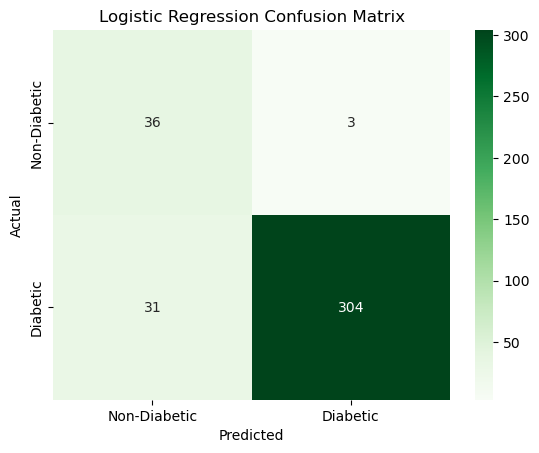

In [942]:
# creating the confusion matrix for Logistic Regression
log_reg_cm = confusion_matrix(y_test, y_predict) 

# plotting confusion matrix for visual interpretation of misclassifications
plt.figure()
sns.heatmap(log_reg_cm, annot=True, fmt='d', cmap='Greens', xticklabels=['Non-Diabetic', 'Diabetic'], yticklabels=['Non-Diabetic', 'Diabetic'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Logistic Regression Confusion Matrix')
plt.show()

--- KNN- --

In [944]:
# initialising the KNN model with 5 neighbors default value for simplicity
k_nearest = KNeighborsClassifier(n_neighbors=5)

In [945]:
# fitting the KNN model to the scaled training data
k_nearest.fit(X_train_scaled, y_train_bal)

KNeighborsClassifier()

In [946]:
# predicting using the trained KNN model with scaled test data
y_predict_knn = k_nearest.predict(X_test_scaled)

In [947]:
# evaluating KNN model performance on the test set
train_acc_knn = k_nearest.score(X_train_scaled, y_train_bal)
test_acc_knn = k_nearest.score(X_test_scaled, y_test)

# print accuracies
print(f'Train Accuracy: {train_acc_knn:.2f}')
print(f'Test Accuracy: {test_acc_knn:.2f}')

# print the classification report for precision, recall, and F1 score
print('KNN Classification Report\n', classification_report(y_test, y_predict_knn))

Train Accuracy: 0.97
Test Accuracy: 0.93
KNN Classification Report
               precision    recall  f1-score   support

           0       0.60      0.90      0.72        39
           1       0.99      0.93      0.96       335

    accuracy                           0.93       374
   macro avg       0.80      0.91      0.84       374
weighted avg       0.95      0.93      0.93       374



KNN Confusion Matrix Visualised

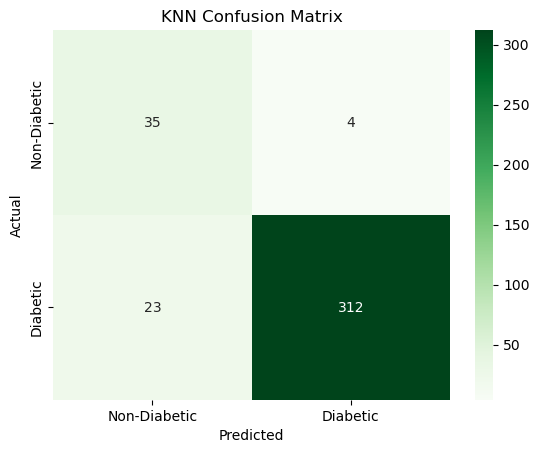

In [949]:
# creating the confusion matrix for KNN
knn_cm = confusion_matrix(y_test, y_predict_knn)

# print the confusion matrix to see true/false positives and negatives
plt.figure()
sns.heatmap(knn_cm, annot=True, fmt='d', cmap='Greens', xticklabels=['Non-Diabetic', 'Diabetic'], yticklabels=['Non-Diabetic', 'Diabetic'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('KNN Confusion Matrix')
plt.show()

Visualising best Ks

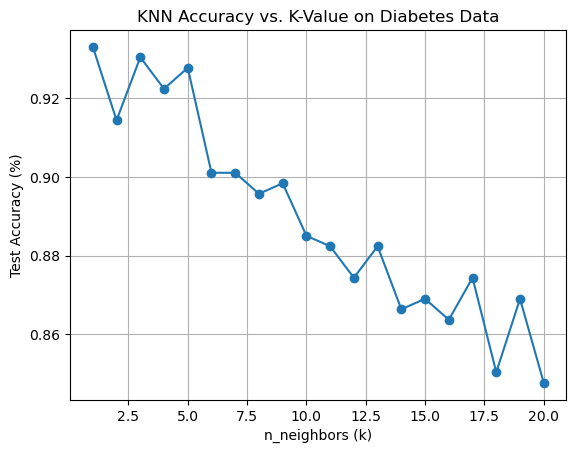

In [951]:
# creating empty lists to store accuracy and corresponding k values
acc = []
md = []

# iterating over k values from 1 to 20
for i in range(1, 21):
    knn = KNeighborsClassifier(n_neighbors=i) # initialise KNN model with current k
    knn.fit(X_train_scaled, y_train_bal)  # Train on balanced & scaled data
    acc.append(knn.score(X_test_scaled, y_test))  # test accuracy
    md.append(i)

# plotting KNN accuracy for different k values
plt.figure()
plt.plot(md, acc, label='KNN', marker='o', linestyle='-')
plt.xlabel('n_neighbors (k)')
plt.ylabel('Test Accuracy (%)')
plt.title('KNN Accuracy vs. K-Value on Diabetes Data')
plt.grid(True)
plt.show()

--- SVC ---

In [953]:
# initialising the SVC model with default parameters
svc_rbf = SVC(kernel='rbf', C=1, gamma='scale', random_state=42)

In [954]:
# training the SVC model on scaled training data
svc_rbf.fit(X_train_scaled, y_train_bal)

SVC(C=1, random_state=42)

In [955]:
# predicting with the SVC model using the scaled test data
svc_y_predict = svc_rbf.predict(X_test_scaled)

In [956]:
# calculating train and test accuracy for SVC model
svc_trACC = svc_rbf.score(X_train_scaled, y_train_bal)
svc_tesACC = svc_rbf.score(X_test_scaled, y_test)

# print accuracies
print(f'Train Accuracy: {svc_trACC:.2f}')
print(f'Test Accuracy: {svc_tesACC:.2f}')


# print the classification report
print('SVC Classification Report\n', classification_report(y_test, svc_y_predict))

Train Accuracy: 0.98
Test Accuracy: 0.95
SVC Classification Report
               precision    recall  f1-score   support

           0       0.70      0.85      0.77        39
           1       0.98      0.96      0.97       335

    accuracy                           0.95       374
   macro avg       0.84      0.90      0.87       374
weighted avg       0.95      0.95      0.95       374



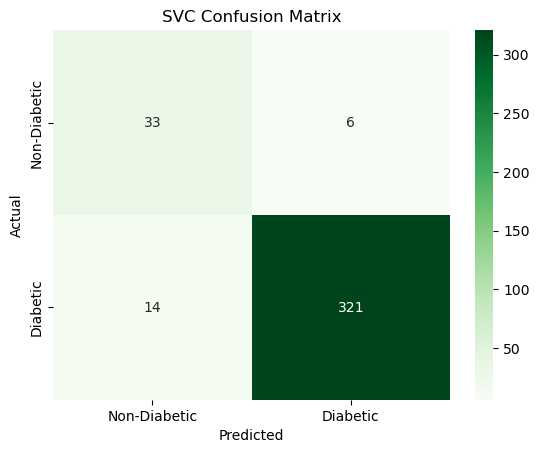

In [957]:
# creating the confusion matrix for SVC
svc_cm = confusion_matrix(y_test, svc_y_predict)

# plotting confusion matrix for visual interpretation of misclassifications
plt.figure()
sns.heatmap(svc_cm, annot=True, fmt='d', cmap='Greens', xticklabels=['Non-Diabetic', 'Diabetic'], yticklabels=['Non-Diabetic', 'Diabetic'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('SVC Confusion Matrix')
plt.show()

--- Naïve Bayes ---

In [959]:
# initialising the Naive Bayes model
nb_gaussian = GaussianNB()

In [960]:
# training the Naive Bayes model on scaled training data
nb_gaussian.fit(X_train_scaled, y_train_bal)

GaussianNB()

In [961]:
# predicting with the Naive Bayes model using the scaled test data
nb_y_predict = nb_gaussian.predict(X_test_scaled)

In [962]:
# calculating train and test accuracy for Naive Bayes model
nb_trACC = nb_gaussian.score(X_train_scaled, y_train_bal)
nb_tesACC = nb_gaussian.score(X_test_scaled, y_test)

# print accuracies
print(f'Train Accuracy: {nb_trACC:.2f}')
print(f'Test Accuracy: {nb_tesACC:.2f}')

# print the classification report
print('Naive Bayes Classification Report\n',classification_report(y_test, nb_y_predict))

Train Accuracy: 0.95
Test Accuracy: 0.93
Naive Bayes Classification Report
               precision    recall  f1-score   support

           0       0.63      0.85      0.73        39
           1       0.98      0.94      0.96       335

    accuracy                           0.93       374
   macro avg       0.81      0.89      0.84       374
weighted avg       0.95      0.93      0.94       374



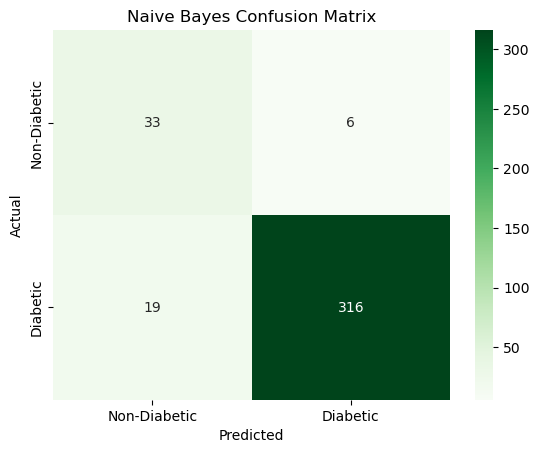

In [963]:
# creating the confusion matrix for Naive Bayes
nb_cm = confusion_matrix(y_test, nb_y_predict)

# plotting confusion matrix for visual interpretation of misclassifications
plt.figure()
sns.heatmap(nb_cm, annot=True, fmt='d', cmap='Greens', xticklabels=['Non-Diabetic', 'Diabetic'], yticklabels=['Non-Diabetic', 'Diabetic'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Naive Bayes Confusion Matrix')
plt.show()

--- XGBoost ---

In [965]:
# initialising the XGBoost model with default parameters
xgbst = XGBClassifier(objective = 'binary:logistic', random_state=42)

In [966]:
# training the XGBoost model on scaled training data
xgbst.fit(X_train_scaled, y_train_bal)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)

In [967]:
# predicting with the XGBoost model using the scaled test data
xgbst_y_predict = xgbst.predict(X_test_scaled)

In [968]:
# calculating train and test accuracy for XGBoost model
xgb_trACC = xgbst.score(X_train_scaled, y_train_bal)
xgb_tesACC = xgbst.score(X_test_scaled, y_test)

# print accuracies
print(f'Train Accuracy: {xgb_trACC:.2f}')
print(f'Test Accuracy: {xgb_tesACC:.2f}')

# print the classification report
print('XGBoost Classification Report:\n',classification_report(y_test, xgbst_y_predict))

Train Accuracy: 1.00
Test Accuracy: 0.96
XGBoost Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.87      0.81        39
           1       0.98      0.97      0.98       335

    accuracy                           0.96       374
   macro avg       0.87      0.92      0.89       374
weighted avg       0.96      0.96      0.96       374



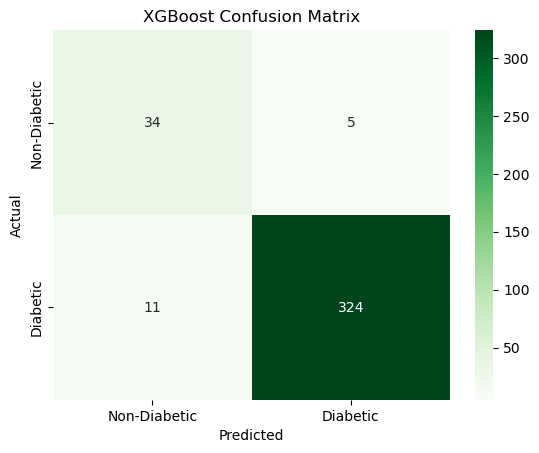

In [969]:
# creating the confusion matrix for XGBoost
xgbst_cm = confusion_matrix(y_test, xgbst_y_predict)

# plotting confusion matrix for visual interpretation of misclassifications
plt.figure()
sns.heatmap(xgbst_cm, annot=True, fmt='d', cmap='Greens', xticklabels=['Non-Diabetic', 'Diabetic'], yticklabels=['Non-Diabetic', 'Diabetic'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('XGBoost Confusion Matrix')
plt.show()

Hyperperameter Tuning

--- KNN Tuning---

In [972]:
# defining parameter grid for KNN - range of k values
param_knn = {'n_neighbors' : list(range(2,21))}



In [973]:
# performing grid search with 5-fold cross-validation for KNN
k_nearest_gs = GridSearchCV(knn, param_knn, cv=5, scoring='f1', n_jobs=-1, return_train_score=True)

In [974]:
# fitting the grid search model on scaled training data
k_nearest_gs.fit(X_train_scaled, y_train_bal)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(n_neighbors=20), n_jobs=-1,
             param_grid={'n_neighbors': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,
                                         14, 15, 16, 17, 18, 19, 20]},
             return_train_score=True, scoring='f1')

In [975]:
# retrieving the best k value from grid search
best_k_tuned = k_nearest_gs.best_params_['n_neighbors']
print(f'Best K Value: {best_k_tuned}')

Best K Value: 3


In [976]:
# extracting the best KNN model from grid search
best_knn = k_nearest_gs.best_estimator_
print(f'Best Tuned KNN F1 score on Train Data: {k_nearest_gs.best_score_}')

Best Tuned KNN F1 score on Train Data: 0.9584929133226213


In [977]:
# predicting with the best KNN model using the scaled test data
knn_tuned_y_predict = best_knn.predict(X_test_scaled)

In [978]:
# calculating train and test accuracy for tuned KNN model
knn_gs_trACC = best_knn.score(X_train_scaled, y_train_bal)
knn_gs_tesACC = best_knn.score(X_test_scaled, y_test)

# print accuracies
print(f'Train Accuracy: {knn_gs_trACC:.2f}')
print(f'Test Accuracy: {knn_gs_tesACC:.2f}')

# Tuned Classification Report
print('Tuned KNN Classification Report\n', classification_report(y_test, knn_tuned_y_predict))

Train Accuracy: 0.99
Test Accuracy: 0.93
Tuned KNN Classification Report
               precision    recall  f1-score   support

           0       0.62      0.85      0.72        39
           1       0.98      0.94      0.96       335

    accuracy                           0.93       374
   macro avg       0.80      0.89      0.84       374
weighted avg       0.94      0.93      0.94       374



KNN Validation Curve

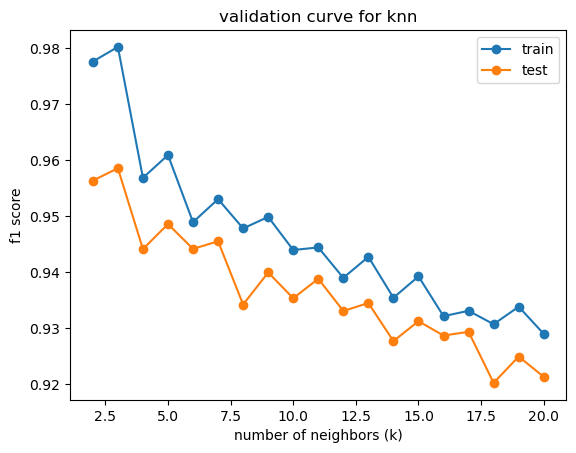

In [980]:
# extracting cross-validation results into a dataframe
results = pd.DataFrame(k_nearest_gs.cv_results_)

# gettting k values and corresponding mean train and test scores
k_values = results['param_n_neighbors']
train_scores = results['mean_train_score']
test_scores = results['mean_test_score']

# plot the validation curve for knn
plt.plot(k_values, train_scores, label='train', marker='o')
plt.plot(k_values, test_scores, label='test', marker='o')
plt.xlabel('number of neighbors (k)')
plt.ylabel('f1 score')
plt.title('validation curve for knn')
plt.legend()
plt.show()

Hypermater Tuning SVC

In [982]:
# defining parameter grid for SVC - testing different C, gamma and kernel values
param_svc = {'C': [0.1, 1, 10],
                  'gamma': [0.001, 0.01, 0.1, 1, 'scale'],
                  'kernel': ['rbf', 'poly', 'sigmoid']}

In [983]:
# performing grid search with 5-fold cross-validation for SVC
svc_gs = GridSearchCV(SVC(class_weight='balanced'), param_svc, cv=5, scoring='f1', n_jobs=-1, return_train_score=True)

In [984]:
# fitting the grid search model on scaled training data
svc_gs.fit(X_train_scaled, y_train_bal)

GridSearchCV(cv=5, estimator=SVC(class_weight='balanced'), n_jobs=-1,
             param_grid={'C': [0.1, 1, 10],
                         'gamma': [0.001, 0.01, 0.1, 1, 'scale'],
                         'kernel': ['rbf', 'poly', 'sigmoid']},
             return_train_score=True, scoring='f1')

In [985]:
# retrieving the best parameters from grid search
svc_best_param = svc_gs.best_params_
print(f'Best SVC Parameters: {svc_best_param}')


Best SVC Parameters: {'C': 1, 'gamma': 1, 'kernel': 'rbf'}


In [986]:
# extracting the best SVC model from grid search
svc_best_model = svc_gs.best_estimator_
print(f'Best SVC F1 score: {svc_best_model}')

Best SVC F1 score: SVC(C=1, class_weight='balanced', gamma=1)


In [987]:
# predicting with the best SVC model using the scaled test data
svc_tuned_y_predict = svc_best_model.predict(X_test_scaled)

In [988]:
# calculating train and test accuracy for tuned SVC model
svc_gs_trACC = svc_best_model.score(X_train_scaled, y_train_bal)
svc_gs_tesACC = svc_best_model.score(X_test_scaled, y_test)

# print accuracies
print(f'Train Accuracy: {svc_gs_trACC:.2f}')
print(f'Test Accuracy: {svc_gs_tesACC:.2f}')

print('Tuned SVC Classification Report\n', classification_report(y_test, svc_tuned_y_predict))

Train Accuracy: 1.00
Test Accuracy: 0.95
Tuned SVC Classification Report
               precision    recall  f1-score   support

           0       0.86      0.62      0.72        39
           1       0.96      0.99      0.97       335

    accuracy                           0.95       374
   macro avg       0.91      0.80      0.84       374
weighted avg       0.95      0.95      0.95       374



SVC Validation Curve

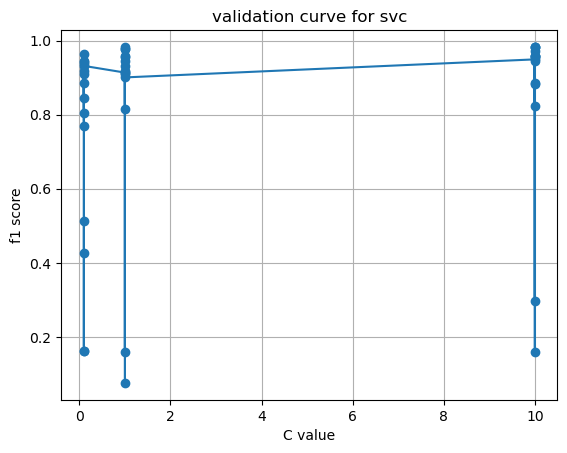

In [990]:
# extract grid search results into a dataframe
results_svc = pd.DataFrame(svc_gs.cv_results_)

# get C values and mean test scores
c_values = results_svc['param_C']
test_scores = results_svc['mean_test_score']

# plot validation curve for svc
plt.figure()
plt.plot(c_values, test_scores, marker='o')
plt.xlabel('C value')
plt.ylabel('f1 score')
plt.title('validation curve for svc')
plt.grid(True)
plt.show()

Hyperameter Tuning XGBoost

In [992]:
# defining parameter grid for XGBoost to tune tree depth, learning rate and subsampling
param_xgboost = {'n_estimators': [50, 100],
                  'max_depth': [3, 5, 7],
                  'learning_rate': [0.01, 0.1],
                  'subsample': [0.8, 1.0]}

In [993]:
# performing grid search with 5-fold cross-validation for XGBoost
xgboost_gs = GridSearchCV(XGBClassifier(random_state=42, eval_metric='logloss'),
                               param_xgboost, cv=5, scoring='f1', n_jobs=-1)

In [994]:
# fitting the grid search model on scaled training data
xgboost_gs.fit(X_train_scaled, y_train_bal)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='logloss', feature_types=None,
                                     feature_weights=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraint...
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1], 'max_depth': [3, 5, 7],
                         'n_estimators': [50, 100], 'subsample': [0.8, 1.0]},
             scoring='f1')

In [995]:
# retrieving the best parameters from grid search
xgboost_best_param = xgboost_gs.best_params_
print(f'Best XGBoost Parameters:\n {xgboost_best_param}')

Best XGBoost Parameters:
 {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100, 'subsample': 1.0}


In [996]:
# extracting the best XGBoost model from grid search
xgboost_best_model = xgboost_gs.best_estimator_

In [997]:
# predicting with the best XGBoost model using the scaled test data
xgboost_tuned_y_predict = xgboost_best_model.predict(X_test_scaled)

In [998]:
# calculating train and test accuracy for tuned XGBoost model
xgb_gs_trACC = xgboost_best_model.score(X_train_scaled, y_train_bal)
xgb_gs_tesACC = xgboost_best_model.score(X_test_scaled, y_test)

# print accuracies
print(f'Train Accuracy: {xgb_gs_trACC:.2f}')
print(f'Test Accuracy: {xgb_gs_tesACC:.2f}')

# print the classification report
print('Tuned XGBoost Classification Report:\n', classification_report(y_test, xgboost_tuned_y_predict))

Train Accuracy: 1.00
Test Accuracy: 0.96
Tuned XGBoost Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.90      0.82        39
           1       0.99      0.97      0.98       335

    accuracy                           0.96       374
   macro avg       0.87      0.93      0.90       374
weighted avg       0.96      0.96      0.96       374



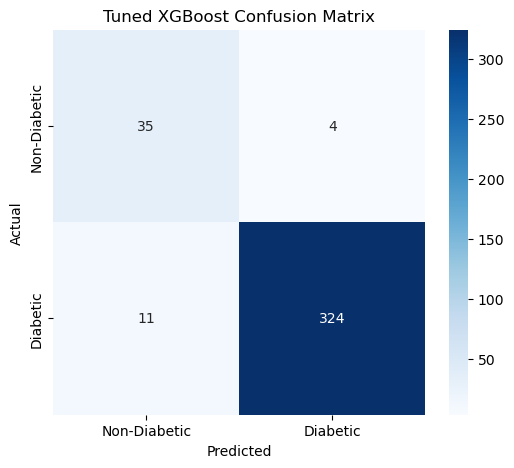

In [999]:
# creating the confusion matrix for tuned XGBoost
xgboost_gs_cm = confusion_matrix(y_test, xgboost_tuned_y_predict)

# plotting confusion matrix for visual interpretation of misclassifications
plt.figure(figsize=(6, 5))
sns.heatmap(xgboost_gs_cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Diabetic', 'Diabetic'], yticklabels=['Non-Diabetic', 'Diabetic'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Tuned XGBoost Confusion Matrix')
plt.show()

F1 Score Barplot for all Models

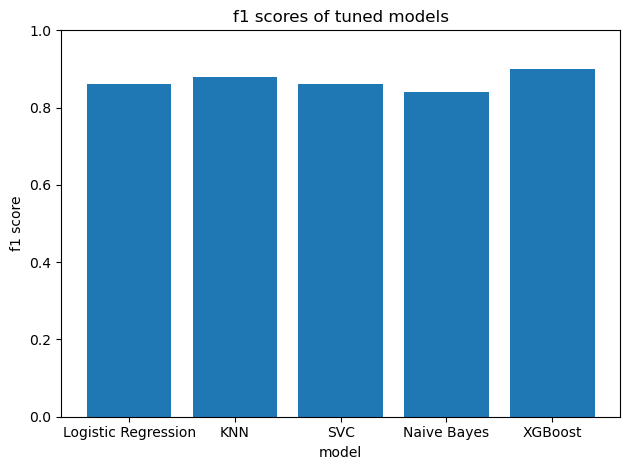

In [1001]:
# f1 scores for each tuned model based on final outputs
f1_scores = [0.86, 0.88, 0.86, 0.84, 0.90]
model_names = ['Logistic Regression', 'KNN', 'SVC', 'Naive Bayes', 'XGBoost']

# create bar plot for f1 scores
plt.figure()
plt.bar(model_names, f1_scores)
plt.xlabel('model')
plt.ylabel('f1 score')
plt.title('f1 scores of tuned models')
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

Comparing Models ROC and AUC 

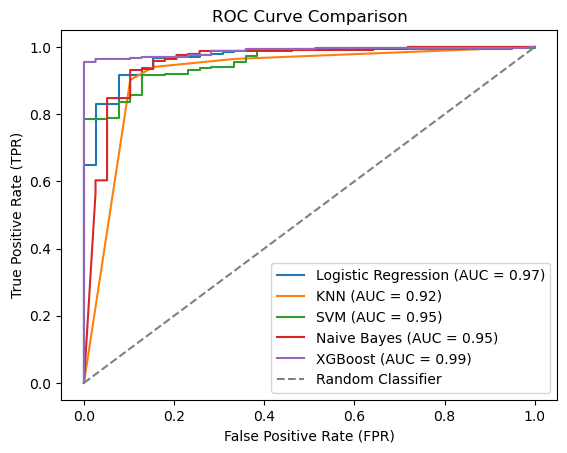

In [1003]:
# getting predicted probabilities or decision scores for ROC curve
log_reg_probs = log_reg.predict_proba(X_test_scaled)[:, 1]
knn_probs = best_knn.predict_proba(X_test_scaled)[:, 1] 
svc_probs = svc_best_model.decision_function(X_test_scaled)
nb_probs = nb_gaussian.predict_proba(X_test_scaled)[:, 1]
xgboost_probs = xgboost_best_model.predict_proba(X_test_scaled)[:, 1]

# storing model names and their probabilities/scores
models = {
    'Logistic Regression': log_reg_probs,
    'KNN': knn_probs,
    'SVC': svc_probs,
    'Naive Bayes': nb_probs,
    'XGBoost': xgboost_probs}

# plotting ROC curves for each model
plt.figure()
for name, probs in models.items():
    fpr, tpr, _ = roc_curve(y_test, probs)
    auc_score = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {auc_score:.2f})')

# plotting baseline random classifier
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Classifier')

# formatting plot
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve Comparison')
plt.legend()
plt.show()